### InceptionV3

Sistemul utilizat in cadrul articolului foloseste arhitectura InceptionV3. Aceasta arhitectura ofera o acuratete de 99.20% cu o latenta de 94.1ms pe device-urile IoT, o metoda sigura, performanta si robusta in cazul schimbarilor conditiilor de lumina sau a orientarilor faciale.

### Eliminarea problemelor

Un sistem care functioneaza fara probleme si in timp real este reprezentat prin ecuatia (1) unde variabilele sunt:<br>
**P** - Performanta sistemului (acuratetea)<br>
**S** - Parametrii sistemului<br>
**W** - Weight-urile din cadrul retelei neuronale<br>
**A** - Arhitectura sistemului<br>
**H** - Setul de arhitecturi care pot fi folosite<br>
**T** - Restrangerea de timp pentru predictie (timp de raspuns sau latenta)<br>

![title](Images/Eq1.png)

### Scop

Scopul acestei abordari este detectarea momentelor in care pacientii clipesc si maparea acestora la un dictionar de cuvinte. Pentru a se ajunge la asta se detecteaza toate starile 'Open' urmate de stari 'Closed'.

### Faze de procesare

![title](Images/Phases.png)

### Faza 1. Capturarea si salvarea mai multor cadre

Metoda de obtinere a datelor pentru ConvNet este folosirea unei camere atasata de un sistem IoT pentru capturarea cadrelor. Imaginile salvate vor avea dimensiuni de 80 x 70 pixeli. Pentru scopul acestui proiect, aceasta parte nu va fi implementata.

### Faza 2. Prezicerea continutului imaginii.

Se compara arhitecturile **SqueezeNet**, **ResNet**, **InceptionV3**, **DenseNet**.
Se antreneaza retelele pentru diferite dimensiuni de batch care dau cele mai bune rezultate.

**Setul de date** folosit este 'eye dataset' de la Media Research Lab (MRL). Acest set de date contine 84898 imagini cu ochi ai 37 de indivizi (33 barbati si 4 femei).<br>
Dataset-ul contine 6 clase: 'gender', 'glasses', 'eye state', 'reflections', 'lighting condition' si 'sensor resolution'.

Am preluat acest set de date de pe site-ul oficial MRL de la link-ul http://mrl.cs.vsb.cz/eyedataset . Aceste date se regasesc sub forma pozelor cu denumiri care specifica cele 6 clase a dataset-ului.<br>Ordinea proprietatilor este: <br> **SubjectID**, **ImageID**<br>**gender**[0 - man, 1 - woman]<br> **glasses**[0 - no, 1 - yes]<br> **eye state** [0 - closed, 1 - open]<br> **reflections** [0 - none, 1 - small, 2 - big]<br> **lighting conditions** [0 - bad, 1 - good]<br> **sensor ID** [01 - RealSense, 02 - IDS, 03 - Aptina]<br>

Un exemplu de denumire: s0012_03054_0_1_0_2_1_01.<br>Asta inseamna ca ochii sunt ai subiectului 12, poza are id-ul 03054, subiectul e barbat, poarta ochelari, ochiul este inchis, exista o reflexie mare in poza, luminozitate buna, senzorul folosit a fost RealSense

# Convolutional. 

Un fisier .CSV s-a realizat pentru fiecare subiect prin comanda `dir | Get-ChildItem -BaseName -Recurse | Export-Csv Data.csv`, iar apoi datele din CSV au fost impartite pe coloane in functie de separatorul `_`.

Mai departe am ales sa folosesc libraria Keras pentru a transforma in date imagini de diferite dimensiuni din setul de date descarcat.

In [1]:
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
data = pd.read_csv("Data.csv")

In [3]:
data

,SubjectID,ImageID,Gender,Glasses,Reflections,Lighting,SensorID,Eye_state
0,s0001,1,0,0,0,0,1,0
1,s0001,2,0,0,0,0,1,0
2,s0001,3,0,0,0,0,1,0
3,s0001,4,0,0,0,0,1,0
4,s0001,5,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
84893,s0037,10253,1,1,0,0,1,1
84894,s0037,10254,1,1,0,0,1,1
84895,s0037,10255,1,1,0,0,1,1
84896,s0037,10256,1,1,0,0,1,1


In [4]:
h,w = 90,90 # desired height and width
batch_size = 64
N_images = 84898 #total number of images

In [5]:
datagen = ImageDataGenerator(
    rescale=1./255)

In [6]:
data_iterator = datagen.flow_from_directory(
    './Eyes',
    shuffle = 'False',
    color_mode='grayscale',
    target_size=(h, w),
    batch_size=batch_size,
    class_mode = 'binary')

Found 84898 images belonging to 37 classes.


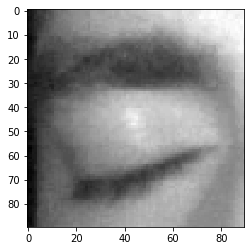

In [7]:
plt.imshow(data_iterator[0][0][63].squeeze(), cmap = "gray")

In [8]:
data_iterator[0][0].shape

(64, 90, 90, 1)

In [9]:
data_iterator[0][0][0][0].shape

(90, 1)

In [10]:
def extract_images(generator, sample_count):
    images = np.zeros(shape=(sample_count, h, w, 1))
    i = 0
    for images_batch, labels_batch in generator: # we are looping over batches
        images[i*batch_size : (i+1)*batch_size] = images_batch
        i += 1
        if i*batch_size >= sample_count:
            # we must break after every image has been seen once, because generators yield indifinitely in a loop
            break
    return images

images = extract_images(data_iterator, 84864)

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

Am ales sa creez un model secvential care are urmatoarele layere:
Un layer de conversie 2D,
Un layer de MaxPooling
Un layer de Flatten
Un layer de softmax care va returna 2 output-uri (unul pentru fiecare clasa posibila)

In [12]:
from keras.layers import GRU, LeakyReLU

In [13]:
model = Sequential()
num_filters = 8
filter_size = 3
pool_size = 2

model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(90, 90, 1)),
  Conv2D(16, kernel_size=3, activation='relu'),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(8, activation = 'tanh'),
  Dense(64, input_dim=60, activation='relu'),
  Dense(32, activation='softplus'),
  Dense(2, activation='softmax'), # Softmax va avea 2 layere. Cate unul pt fiecare clasa (Open/Closed)
])

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.compile(
    'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [15]:
y_labels = data.iloc[:,-1]

In [16]:
train_images = images[0:70000]
test_images = images[70000:84864]
train_labels = y_labels[0:70000]
test_labels = y_labels[70000:84864]

In [17]:
np.unique(train_labels)

array([0, 1], dtype=int64)

In [18]:
from keras.utils import to_categorical

model.fit(
  train_images,
  to_categorical(train_labels),
  epochs=3,
  validation_data=(test_images, to_categorical(test_labels)),
)

Instructions for updating:
Use tf.cast instead.
Train on 70000 samples, validate on 14864 samples
Epoch 1/3
70000/70000 [==============================] - 188s 3ms/step - loss: 0.6951 - accuracy: 0.4978 - val_loss: 0.7044 - val_accuracy: 0.4416
Epoch 2/3
70000/70000 [==============================] - 191s 3ms/step - loss: 0.6943 - accuracy: 0.4993 - val_loss: 0.6940 - val_accuracy: 0.4416
Epoch 3/3
70000/70000 [==============================] - 187s 3ms/step - loss: 0.6941 - accuracy: 0.5011 - val_loss: 0.6957 - val_accuracy: 0.4416


In [19]:
model.save_weights('cnn.h5')

In [20]:
predictions = model.predict(images[500:600])

In [21]:
predictions

array([[0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [0.5102072, 0.4897928],
       [

In [22]:
preds = np.argmax(predictions, axis=1)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [23]:
print(train_labels[0:5])

0    0
1    0
2    0
3    0
4    0
Name: Eye_state, dtype: int64


### Blink to text

Acum ca avem un algoritm care detecteaza clipitul, putem sa alcatuim un dictionar care sa transforme aceste informatii in propozitii.

In [24]:
d = dict()
d['1'] = "Yes"
d['101'] = "No"
d['10101'] = "Hi"
d['1010101'] = "I am"
d['101010101'] = "Good"
d['10101010101'] = "Thanks"
d['1010101010101'] = "How are you?"

In [25]:
def convert_sequence(seq):
    string = ""
    for number in seq:
        string += str(number)
    return string

In [26]:
string = convert_sequence([1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1])
string

'11111111000000111111111'

In [27]:
def stringClean(string):
    if not string:
        return ""
    if len(string) == 1:
        return string
    if string[0] == string[1]:
        return stringClean(string[1:])
    return string[0] + stringClean(string[1:])

In [28]:
string = stringClean(string)
d[string]

'No'